In [1]:
"""
This script creates a figure of the components 
of the 2D mass balance, date and altitude.
"""

import xarray as xr
import pandas as pd
import numpy as np
import datetime
from dateutil import tz
import netCDF4
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from my_fun.create_date import create_date
from my_fun.nan_helper import nan_helper
from scipy.signal import savgol_filter
from my_fun.reverse_colourmap import reverse_colourmap
import matplotlib as mpl
import matplotlib as mpl


In [2]:
filename_nc  = '../../data/output/Peru_out_1_20160901-20170831.nc'
dir_graphics   = 'out'
name_fig     = 'MB_time_ele'

ds = xr.open_dataset(filename_nc)

time_nc = ds['time'].values
mask_nc = ds['MASK'].values
lat_nc  = ds['lat'].values        
lon_nc  = ds['lon'].values
dem_nc   = ds['HGT'].values
lat_n = len(lat_nc)
lon_n = len(lon_nc)


In [3]:
date_day = create_date(time_nc)
com_SEB  = np.zeros((len(time_nc),14)) 
point_g = np.sum(mask_nc[mask_nc==1])
elev_g  = np.zeros((int(point_g),1))

z = 0
for i in range(lat_n):
    for j in range(lon_n):
            if mask_nc[i,j] == 1:
                var1 = dem_nc[i,j]
                elev_g[z,0] = var1
                z = z+1

var_t   = np.zeros((int((len(time_nc)+1)/24),1))
t1      = 0
for i in range(len(var_t)):
    time_nc1 = time_nc[t1]
    t1       = t1+24
    x = pd.to_datetime(time_nc1)
    x1 = time.mktime(x.timetuple())
    var_t[i,0] = x1


elev_g_20 = np.arange(np.min(elev_g),np.max(elev_g),10) 

var1 = np.zeros((len(elev_g_20),len(var_t)))
var1x = np.zeros((len(elev_g),len(var_t)))
var2 = np.zeros((len(elev_g),len(var_t)))

t1   = 0
t2   = 24
for t in range(len(var_t)):
    z = 0
    var_nc    = ds['MB'][t1:t2,:,:].values
    var_nc_day = np.sum(var_nc,axis=0)
    var_nc = np.zeros((len(elev_g),1))

    var_nc1    = ds['SNOWHEIGHT'][t1:t2,:,:].values
    var_nc_day1 = var_nc1[23,:,:]
    var_nc1 = np.zeros((len(elev_g),1))
    z1 = 0
    for i in range(lat_n):
        for j in range(lon_n):
                if mask_nc[i,j] == 1:
                    var_nc[z1,0]   = var_nc_day[i,j]
                    var_nc1[z1,0]  = var_nc_day1[i,j]
                    z1 = z1+1
    t1 = t1+24
    t2 = t2+24
    var2x = np.concatenate((elev_g, var_nc), axis=1)
    var3x = var2x[np.lexsort(([var2x[:, i] for i in range(var2x.shape[1]-1, -1, -1)]))]

    var4x = np.concatenate((elev_g, var_nc1), axis=1)
    var5x = var4x[np.lexsort(([var4x[:, i] for i in range(var4x.shape[1]-1, -1, -1)]))]

    var1x[:,t] = var3x[:,1]
    var2[:,t] = var5x[:,1]

    a1 = 0
    a2 = 1
    MB_mean_40 = np.zeros((len(elev_g_20)))
    MB_mean_40[:] = np.nan

    for i in range(len(elev_g_20)-1):
        var_in = np.zeros((len(var3x)))
        var_in[:] = np.nan  
        for j in range(len(var3x)):
            if int(var3x[j,0]) in range(int(elev_g_20[a1]),int(elev_g_20[a2])):
                var_in[j] = var3x[j,1]
        MB_mean_40[i] = np.nanmean(var_in)
        a1 = a1+1
        a2 = a2+1        
    
    for j in range(len(var3x)):
        if var3x[j,0] >= elev_g_20[a1]:
            var_in[j] = var3x[j,1]
    
    MB_mean_40[-1] = np.nanmean(var_in)
    
    nans, x = nan_helper(MB_mean_40)
    MB_mean_40[nans]= np.interp(x(nans), x(~nans), MB_mean_40[~nans])

    var1[:,t] = MB_mean_40

var2[var2<0.1] = np.nan

snow_line = np.zeros(len(var_t))
# snow line

for i in range(len(var_t)):
    if np.nanmin(var2[:,i]) >= 0:
        index_y = np.where(var2[:,i] == np.nanmin(var2[:,i]))
        snow_line[i] = var5x[:,0][index_y]
    else:
        snow_line[i] = np.nan

nans, x = nan_helper(snow_line)
snow_line[nans]= np.interp(x(nans), x(~nans), snow_line[~nans])

cmap = mpl.cm.jet
cmap_r = reverse_colourmap(cmap)


<ipython-input-3-aa81cdddb26d>:70: RuntimeWarning: Mean of empty slice
  MB_mean_40[i] = np.nanmean(var_in)


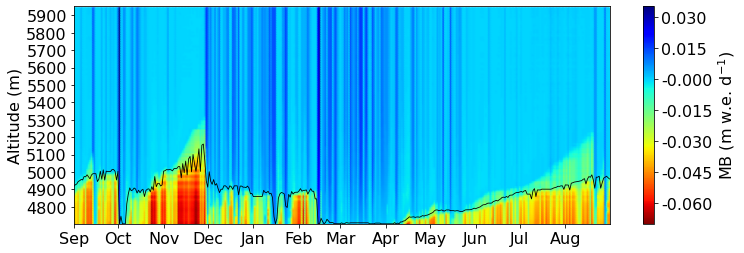

In [5]:
fig, (ax0) = plt.subplots(1,1,figsize=(12,4))    
im0 = ax0.pcolormesh(date_day, elev_g_20, var1, cmap=cmap_r,shading='gouraud')
ax0.plot(date_day,snow_line,'-k', lw=0.8)
lab_cbar = np.round(np.arange(-0.15,0.05,0.015),decimals=3)
#lab_cbar[8] = 0
fig.colorbar(im0,ax=ax0, label = 'MB (m w.e. d$^{-1}$)', format='%1.3f', ticks=lab_cbar)
ax0.set_yticks(np.arange(4800, 6600, 100.0))
ax0.set_ylim(np.min(elev_g), np.max(elev_g))
date_form = mdates.DateFormatter("%b")
ax0.xaxis.set_major_formatter(date_form)
ax0.set_ylabel('Altitude (m)')

font_f = 16
plt.rc('font', size=font_f)          # controls default text sizes
plt.rc('axes', titlesize=font_f)     # fontsize of the axes title
plt.rc('axes', labelsize=font_f)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=font_f)    # fontsize of the tick labels
plt.rc('ytick', labelsize=font_f)    # fontsize of the tick labels
plt.rc('legend', fontsize=font_f)    # legend fontsize


fig.savefig(dir_graphics+'/'+name_fig+'.pdf',dpi = 300, bbox_inches = 'tight', 
             pad_inches = 0.1, format='pdf')